In [5]:
# %reset 
import numpy as np
import xarray as xr
import glob
from xgcm import Grid
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from model_obs_comparisons import WOA_2D_side_by_side, GLODAP_2D_side_by_side, AquaMODIS_side_by_side

from model_obs_comparisons_dicts import (nitrate_dict, 
phosphate_dict, silicate_dict, oxygen_dict, alkalinity_dict, DIC_dict, Chl_dict)

### Notes:
This notebook produces 2D maps from of BGC variables from observational and model datasets. Maps can be drawn interpolated to any depth by changing the `d` parameter in the plot functions. `d=1` is the surface value. 

Currently, these comparisons use the most up to date datasets (e.g. WOA23), despite model output representing 1997.

Model variables to output for additional comparison: 

- CO2 flux (compare to SOCAT)


In [ ]:
DS = xr.dataset()
target_zs = np.arange(0,100)
    
    grid = Grid(z_vals_model, coords={'s_rho': {'center':'s_rho'}}, periodic=False)
    
    with warnings.catch_warnings(action="ignore"):
        transformed = grid.transform(var_ds, 's_rho', target_zs, target_data=z_vals_model.z_rho)
    
    del var_ds
    
    return transformed

In [3]:
model_dir = '/global/homes/a/amwyatt/Cworthy/amwyatt/ucla-roms/'

infiles = glob.glob(model_dir + 'run/CCS/output_more_mem/eastpac25km_rst.1997*000000.nc')
infiles.sort()

model_DS = xr.open_mfdataset(infiles, combine='nested', concat_dim = 'time_counter')
model_grd = xr.open_dataset( model_dir + 'Work/INPUT/epac25km_grd.nc')


## TESTING

In [6]:
def get_z_vals(model_DS, model_grd, verbose=True, Vtransform=4):
    
    if verbose==True:
        print('...stretching vertical coordinate...')

    ds = model_DS
    ds.coords["s_rho"] = np.linspace(-1,0,100)
    ds = ds.sortby('s_rho')

    Cs = xr.DataArray(ds.Cs_r, dims='s_rho')

    if Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - Cs) + Cs * model_grd.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho / model_grd.h)

    if Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + Cs * model_grd.h) / (ds.hc + model_grd.h)
        z_rho = ds.zeta + (ds.zeta + model_grd.h) * Zo_rho
        
    if Vtransform == 4: 
        theta_s = ds.theta_s
        theta_b = ds.theta_b
        
        C = (1 - np.cosh(theta_s * ds.s_rho)) / (np.cosh(theta_s) - 1)
        Cs = (np.exp(theta_b * C) - 1) / (1 - np.exp(-theta_b))
        
        Zo_rho = (ds.hc * ds.s_rho + Cs * model_grd.h) / (ds.hc + model_grd.h)
        z_rho = ds.zeta + (ds.zeta + model_grd.h) * Zo_rho
    
    ds.coords["z_rho"] = z_rho.transpose()
    
    return ds


def get_dz(z_vals_model): 
    dz = z_vals_model.z_rho.diff('s_rho')
    dz.name = 'dz'
    return dz


def model_zgridded(model_DS, model_grd, model_var_name, 
                   target_zs = np.concatenate ( (np.arange(0,-200,-1), np.arange(-200,-5000,-50)) ), 
                   verbose=True):
    
    z_vals_model = get_z_vals(model_DS, model_grd, verbose=verbose)
    var_ds = z_vals_model[model_var_name].load()
    
    if verbose == True:
        print('regridding vertical coordinates')
        
    grid = Grid(z_vals_model, coords={'s_rho': {'center':'s_rho'}}, periodic=False)
    transformed = grid.transform(var_ds, 's_rho', target_zs, target_data=z_vals_model.z_rho)
    
    del var_ds
    
    return transformed

In [61]:
DS = model_zgridded(model_DS, model_grd, model_var_name)

calculating vertical coordinates
...stretching vertical coordinate...
regridding vertical coordinates


/global/homes/a/amwyatt/miniconda3/envs/OAE_atlas/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


(-200.0, 0.0)

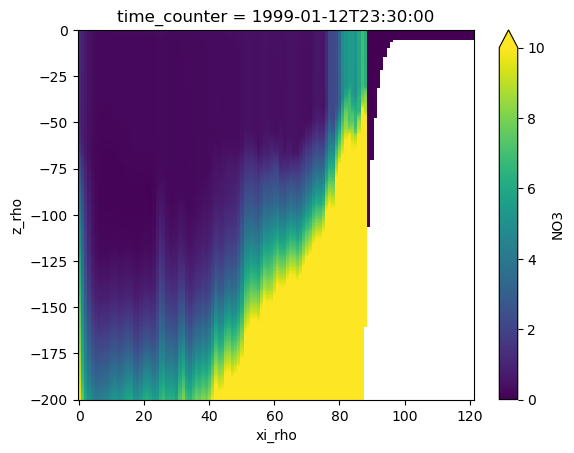

In [74]:
ds2 = DS.isel(time=1, time_counter=10,
            )
ds2.isel(eta_rho=100).plot(y='z_rho', vmax=10)
plt.ylim(-200,0)

In [50]:
z_vals_model = get_z_vals(model_DS, model_grd)[model_var_name]

...stretching vertical coordinate...


(-200.0, 0.0)

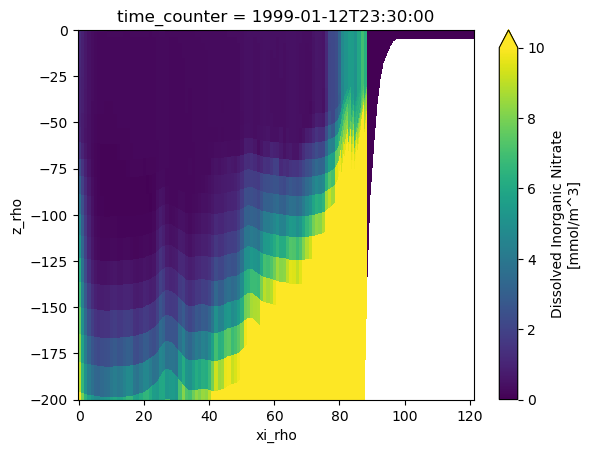

In [60]:
isel = dict(time_counter=10,
            eta_rho=100
)

plt.figure()
z_vals_model.isel(isel).isel(time=1).plot(y='z_rho', vmax=10)
plt.ylim(-200,0)



In [47]:
model_var_name = 'NO3'

z100 = model_zgridded(model_DS, model_grd, model_var_name).sel(z_rho =100, method='nearest')

z1 = model_zgridded(model_DS, model_grd, model_var_name).sel(z_rho =1, method='nearest')

calculating vertical coordinates
...stretching vertical coordinate...
regridding vertical coordinates


/global/homes/a/amwyatt/miniconda3/envs/OAE_atlas/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


calculating vertical coordinates
...stretching vertical coordinate...
regridding vertical coordinates


/global/homes/a/amwyatt/miniconda3/envs/OAE_atlas/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


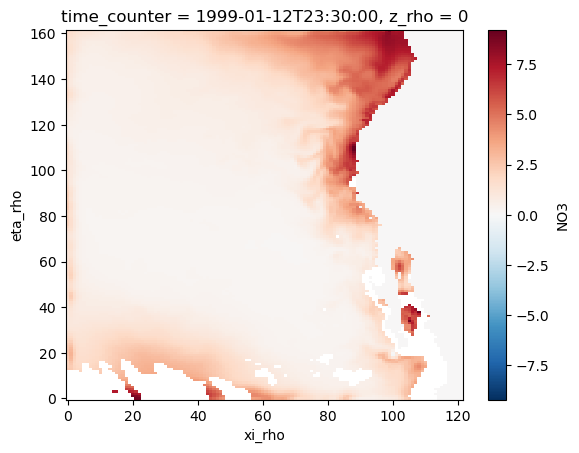

In [78]:
isel=dict(
time_counter=10,
time=1)

plt.figure()
(z100).isel(isel).plot()

### WOA Nutrients

nitrate
standardizing and regridding models and obs datasets...
...calculating comparison time frame...
...stretching vertical coordinate...
...regridding vertical coordinates...


/global/homes/a/amwyatt/miniconda3/envs/OAE_atlas/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/global/homes/a/amwyatt/miniconda3/envs/OAE_atlas/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


starting figure...
...calculating vmax...
...plotting observed field...
...plotting modeled field...
...regridding...
...adding pretty features...
...adding pretty features...
...adding pretty features...


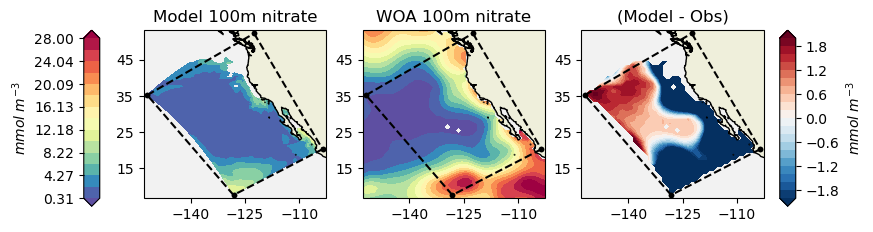

In [9]:
for var_dict in [nitrate_dict, 
                 # phosphate_dict, silicate_dict, oxygen_dict
                ]:
    
    var_name = var_dict['var_name']   
    print(var_name)
    
    fig = WOA_2D_side_by_side(var_dict, model_DS, model_grd, d=100, verbose=True)
   
    # fig.savefig(fig_dir+'Sfc_'+var_name+'_Jan-Mar_map.png', bbox_inches='tight')

nitrate
phosphate
silicate
oxygen


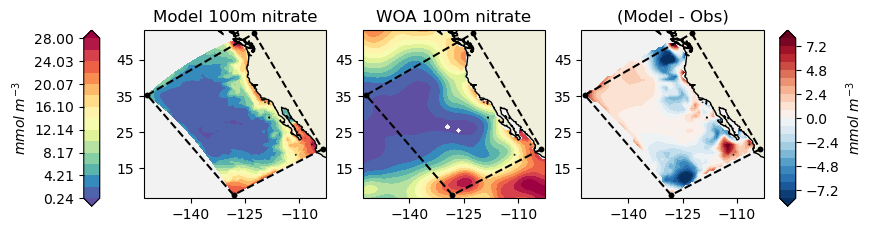

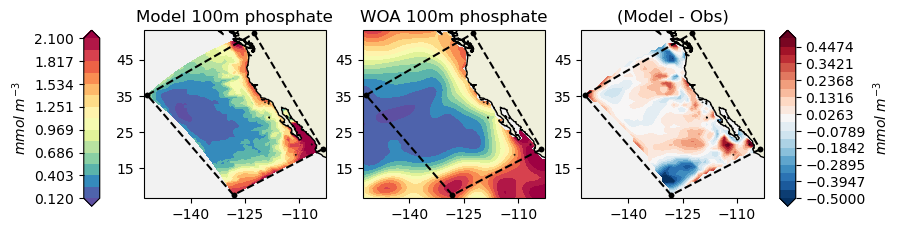

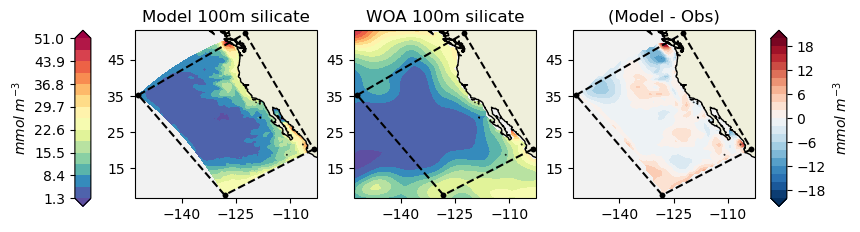

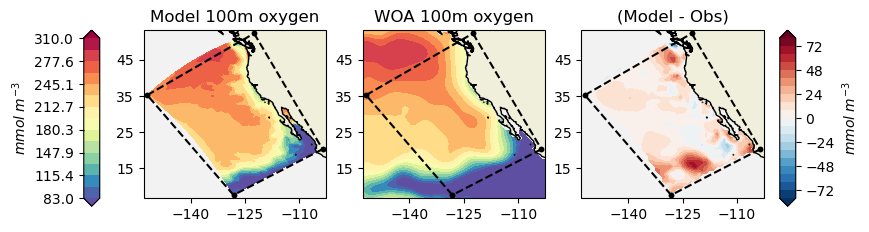

In [6]:
for var_dict in [nitrate_dict, 
                 phosphate_dict, silicate_dict, oxygen_dict
                ]:
    
    var_name = var_dict['var_name']   
    print(var_name)
    
    fig = WOA_2D_side_by_side(var_dict, model_DS, model_grd, d=100)
   
    # fig.savefig(fig_dir+'Sfc_'+var_name+'_Jan-Mar_map.png', bbox_inches='tight')

### GLODAP Carbon

alkalinity
total DIC


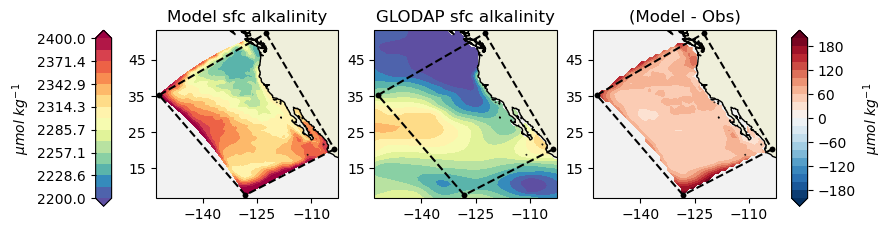

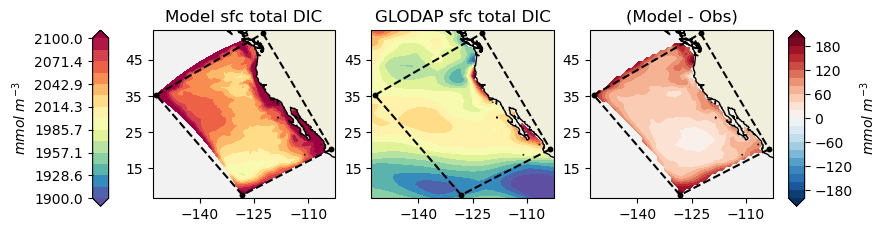

In [7]:
for var_dict in [alkalinity_dict, DIC_dict]:
    
    var_name = var_dict['var_name']   
    print(var_name)
    
    fig = GLODAP_2D_side_by_side(var_dict, model_DS, model_grd, d=1)

alkalinity
total DIC


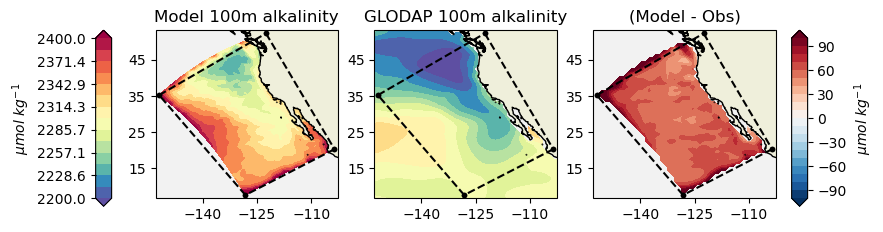

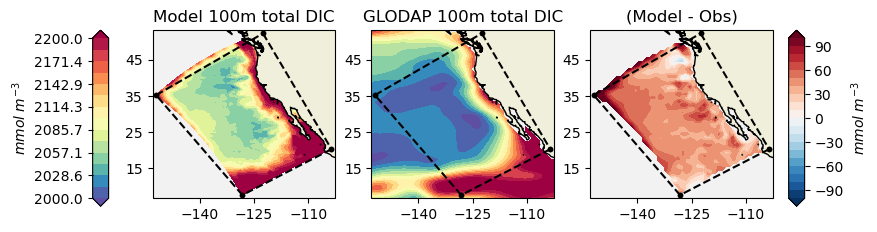

In [8]:
for var_dict in [alkalinity_dict, DIC_dict]:
    
    var_name = var_dict['var_name']   
    print(var_name)
    
    fig = GLODAP_2D_side_by_side(var_dict, model_DS, model_grd, d=100)

### Satellite Chlorophyll

the Aqua Modis data is 4km resolution, making the plotting and regridding on this one really slow. Should get lower res data or coarsen dataset to speed up?

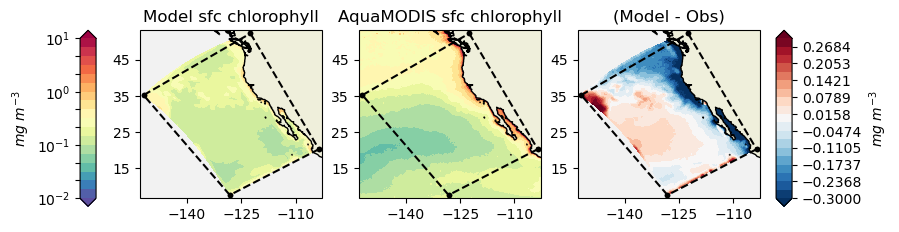

In [9]:
for var_dict in [Chl_dict]:
        
    fig = AquaMODIS_side_by_side(var_dict, model_DS, model_grd)